In [45]:
import numpy as np
import pandas as pd

from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from bleurt import score

scorer = score.BleurtScorer(checkpoint="bleurt-base-128")

import json
import ast
import re
import time

import warnings
warnings.filterwarnings('ignore')

INFO:tensorflow:Reading checkpoint bleurt-base-128.


INFO:tensorflow:Reading checkpoint bleurt-base-128.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [74]:
class DataPreprocessor:
    def __init__(self):
        pass
    def extract_triples(self, input_string):
        tuples = []
        if "</s>" in input_string:
            input_string = input_string.rstrip("</s>").strip()
        if "<|eot_id|>" in input_string:
            input_string =input_string.rstrip("<|eot_id|>").strip()
        
        lines = input_string.split('\n')
        pattern = r'<triplet>\s*(.*?)\s*<subj>\s*(.*?)\s*<obj>\s*(.*)$'

        for line in lines:
            match = re.search(pattern, line)
            if match:
                tuples.append((match.group(1), match.group(2), match.group(3)))
        return tuples
    def convert_df_to_json(self, df):
        json_list_train = []
        json_list_generated = []

        for index, row in df.iterrows():
            input_sentence = row['input_sentence']
            gold_output_text = row['gold_output']
            output_triples = ast.literal_eval(row["extracted_triples"]) # extracted_triples
            
            # Extract triples from gold_output_text
            
            gold_output_triples = self.extract_triples(gold_output_text)
          

            train_json = {
                "text": input_sentence,
                "causal relations": []
            }
            
            # Creating generated JSON
            generated_json = {
                "text": input_sentence, 
                "causal relations": ast.literal_eval(row["extracted_triples"])} # extracted_triples

            for triple in gold_output_triples:
                train_json['causal relations'].append({
                    "src": triple[0],
                    "tgt": triple[1],
                    "direction": triple[2]
                })
            

            json_list_train.append(json.dumps(train_json))
            json_list_generated.append(json.dumps(generated_json))

        return json_list_train, json_list_generated

    def extract_nodes_and_edges(self, train_json, generated_json):
        ground_truth_src_nodes = set()
        ground_truth_tgt_nodes = set()
        predicted_src_nodes = set()
        predicted_tgt_nodes = set()
        ground_truth_edges = []
        predicted_edges = []
        
        for item in train_json:
            item = json.loads(item)
            for relation in item['causal relations']:
                ground_truth_src_nodes.add(relation['src'])
                ground_truth_tgt_nodes.add(relation['tgt'])
                ground_truth_edges.append((relation['src'], relation['direction'].strip(), relation['tgt']))

        for item in generated_json:
            item = json.loads(item)
            for relation in item['causal relations']:
                predicted_src_nodes.add(relation['src'])
                predicted_tgt_nodes.add(relation['tgt'])
                predicted_edges.append((relation['src'], relation['direction'].strip(), relation['tgt']))

        return (list(predicted_src_nodes), list(predicted_tgt_nodes), 
                list(ground_truth_src_nodes), list(ground_truth_tgt_nodes), 
                predicted_edges, ground_truth_edges)






In [75]:


class Metrics:
    def __init__(self):
        pass
    def compute_bleurt(self, candidates, references):
        
        # scores = bleurt.compute(predictions=candidates, references=references)['scores']
        scores = scorer.score(candidates=candidates, references=references) 
        return scores

    def compute_bleu(self, candidates, references):
        scores = []
        
        
        for candidate, reference in zip(candidates, references):
            if len(candidate.split())==0:
                scores.append(0)
                continue
            score = sentence_bleu(reference.split(), candidate)
            scores.append(score)
        return scores

    def compute_meteor(self, candidates, references):
        scores = []
        for candidate, reference in zip(candidates, references):
            if len(candidate.split())==0:
                scores.append(0)
                continue
            score = meteor_score(reference.split(), candidate)
            
            scores.append(score)
        return scores

    def compute_rouge(self, candidates, references):
        scores = []
        scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
        for candidate, reference in zip(candidates, references):
            score = scorer.score(reference, candidate)['rouge1'].fmeasure
         
            scores.append(score)
        return scores

    def compute_verbatim(self, candidates, references):
        scores = np.array(candidates)==np.array(references)
        return scores.astype(int)
    


In [76]:

class ScoreCalculator:
    cache = {}
    def __init__(self, filenames, metrics, thresholds):
        self.filenames = filenames
        self.metrics = metrics
        self.thresholds = thresholds
        self.metric_computer = Metrics()
        self.data_preprocessor = DataPreprocessor()
    def compute_scores(self, nodes1, nodes2, metric):
        candidates = [pred for pred in nodes1 for _ in nodes2]
        references = [ref for _ in nodes1 for ref in nodes2]

        if metric == 'bleurt':
            scores = self.metric_computer.compute_bleurt(candidates, references)            
            
        elif metric == 'bleu':
            scores = self.metric_computer.compute_bleu(candidates, references)
 
        elif metric == 'meteor':
            scores = self.metric_computer.compute_meteor(candidates, references)
        
        elif metric == 'rouge':
            scores = self.metric_computer.compute_rouge(candidates, references)
        
        elif metric == 'verbatim':
            scores = self.metric_computer.compute_verbatim(candidates, references)
        else:
            raise ValueError(f'Unknown metric: {metric}')

        return scores
    
    def find_node_mappings(self, pred_nodes, gt_nodes, node_matrix):
        mappings = {}
        for i, pred_node in enumerate(pred_nodes):
            for j, gt_node in enumerate(gt_nodes):
                if node_matrix[i, j]:
                    if pred_node not in mappings:
                        mappings[pred_node] = []
                    mappings[pred_node].append(gt_node)
        return mappings

    def find_matching_edges(self, pred_edges, gt_edges, pred_to_gt_mappings):
        matched_edges = []
        matched_pred_edges=[]
        for src, dir, tgt in pred_edges:
            dir=dir.strip()
            if src in pred_to_gt_mappings and tgt in pred_to_gt_mappings:
                for mapped_src in pred_to_gt_mappings[src]:
                    for mapped_tgt in pred_to_gt_mappings[tgt]:
                        if (mapped_src, dir, mapped_tgt) in gt_edges and (src,dir,tgt) in pred_edges:
                            if (mapped_src, dir, mapped_tgt) not in matched_edges:
                                matched_edges.append((mapped_src, dir, mapped_tgt))
                            matched_pred_edges.append((src,dir,tgt))
                            
        return matched_pred_edges,matched_edges
    
    def calculate_f1_score(self, tp, fp, fn):
        if tp + fp == 0:  # Check if the denominator is zero
            precision = 0  # If so, set precision to zero to avoid division by zero
        else:
            precision = tp / (tp + fp)
        if tp + fn == 0:  # Check if the denominator is zero
            recall = 0     # If so, set recall to zero to avoid division by zero
        else:
            recall = tp / (tp + fn)
        
        if precision + recall == 0:
            return 0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)
            return f1_score
    def calculate_scores(self):
        scores_df = pd.DataFrame(columns=['Model', 'Metric', 'F1'])
        detailed_scores_df = pd.DataFrame(columns=['Model', 'Metric', 'Row', 'F1'])
        
        for model, filename in self.filenames.items():
        # Check if the file is a .csv or .json
            if filename.endswith('.json'):
                with open(filename) as f:
                    data = json.load(f)
                    train_json, generated_json = data['train'], data['generated']
                    train_json = [json.dumps(item) for item in train_json]
                    generated_json = [json.dumps(item) for item in generated_json]
                    
                    # Convert JSON to DataFrame for row-wise processing
                    df = pd.DataFrame({'train': train_json, 'generated': generated_json})

            else:
                df = pd.read_csv(filename)
                train_json, generated_json = self.data_preprocessor.convert_df_to_json(df)

            for metric in self.metrics:
                threshold = self.thresholds[metric]
                row_f1_scores = []

                for row_idx, row in df.iterrows():
                    single_row_df = pd.DataFrame([row])
                    if filename.endswith('.json'):
                        train_json_row, generated_json_row = [train_json[row_idx]], [generated_json[row_idx]]
                    else:
                        train_json_row, generated_json_row = self.data_preprocessor.convert_df_to_json(single_row_df)
                    
                    predicted_nodes_src_row, predicted_nodes_tgt_row, ground_truth_nodes_src_row, ground_truth_nodes_tgt_row, predicted_edges_row, ground_truth_edges_row = self.data_preprocessor.extract_nodes_and_edges(train_json_row, generated_json_row)
                    # Calculate scores separately for source and target nodes
                    
                    # collect cached results if already computed
                    if filename not in self.cache:
                        ScoreCalculator.cache[filename] = {}
                    if row_idx not in self.cache[filename]:
                        ScoreCalculator.cache[filename][row_idx] = {}
                    if metric not in self.cache[filename][row_idx]:
                        ScoreCalculator.cache[filename][row_idx][metric] = {}
                    if 'src' not in self.cache[filename][row_idx][metric]:
                        ScoreCalculator.cache[filename][row_idx][metric]['src'] = self.compute_scores(predicted_nodes_src_row, ground_truth_nodes_src_row, metric)
                    if 'tgt' not in self.cache[filename][row_idx][metric]:
                        ScoreCalculator.cache[filename][row_idx][metric]['tgt'] = self.compute_scores(predicted_nodes_tgt_row, ground_truth_nodes_tgt_row, metric)

                    all_scores_src = ScoreCalculator.cache[filename][row_idx][metric]['src']
                    all_scores_tgt = ScoreCalculator.cache[filename][row_idx][metric]['tgt']
                    
                    # Create a combined matrix
                    matrix_src = np.zeros((len(predicted_nodes_src_row), len(ground_truth_nodes_src_row)))
                    
                    for i in range(len(predicted_nodes_src_row)):
                        for j in range(len(ground_truth_nodes_src_row)):
                            matrix_src[i, j] = all_scores_src[i * len(ground_truth_nodes_src_row) + j]
                    
                    binary_matrix_src = matrix_src >= threshold
                    
                    matrix_tgt = np.zeros((len(predicted_nodes_tgt_row), len(ground_truth_nodes_tgt_row)))

                    for i in range(len(predicted_nodes_tgt_row)):
                        for j in range(len(ground_truth_nodes_tgt_row)):
                            matrix_tgt[i, j] = all_scores_tgt[i * len(ground_truth_nodes_tgt_row) + j]

                    binary_matrix_tgt = matrix_tgt >= threshold
       

                    # Find mappings for both src and tgt nodes
                    pred_to_gt_mappings_src = self.find_node_mappings(predicted_nodes_src_row, ground_truth_nodes_src_row, binary_matrix_src)
                    pred_to_gt_mappings_tgt = self.find_node_mappings(predicted_nodes_tgt_row, ground_truth_nodes_tgt_row, binary_matrix_tgt)

                    # Combine mappings for both src and tgt nodes
                    pred_to_gt_mappings = pred_to_gt_mappings_src | pred_to_gt_mappings_tgt

                    pred_matched, matched_edges = self.find_matching_edges(predicted_edges_row, ground_truth_edges_row, pred_to_gt_mappings)

      
                    TP = len([edge for edge in matched_edges if edge in ground_truth_edges_row])
                    FP = len(predicted_edges_row) - TP 
                    FN = len(ground_truth_edges_row) - TP
                    
                    F1 = self.calculate_f1_score(TP, FP, FN)

                    row_f1_scores.append(F1)
                    detailed_scores_df = detailed_scores_df.append({'Model': model, 'Metric': metric, 'Row': row_idx, 'F1': F1}, ignore_index=True)
            
                average_f1 = np.mean(row_f1_scores)
                scores_df = scores_df.append({'Model': model, 'Metric': metric, 'F1': average_f1}, ignore_index=True)
        scores_df = scores_df.set_index(['Model', 'Metric']).unstack()
        scores_df.columns = ['_'.join(col).strip() for col in scores_df.columns.values]

        return scores_df.reset_index(), detailed_scores_df



In [77]:
from scipy.stats import spearmanr

def compare_metrics_elo(elo_df, metrics_df):
    # Initialize a dictionary to store Spearman correlations for each metric
    spearman_correlations = {}
    spearman_sentence_metrics = {}
    # Iterate through each metric in the metrics dataframe
    for metric in metrics_df['Metric'].unique():
        # Filter the metrics dataframe for the current metric
        metric_df = metrics_df[metrics_df['Metric'] == metric]
        
        # Initialize lists to store Elo values and metric values
        spearman_correlation = []
        spearman_sentence = {}
        for i in range(20):
            winner = elo_df[elo_df[i]==max(elo_df[i])][i].index[0]


            metric_dfi=metric_df[metric_df["Row"]==i].copy()
            elo_dfi=elo_df[i].copy()

            #remove winner from each metric and elo
            metric_dfi = metric_dfi[metric_dfi['Model'] != winner]
            elo_dfi = elo_dfi.drop(winner)

            
            elo_values = []
            metric_values = []
            for model in metric_dfi['Model']:
               
                elo_row_values = elo_dfi[model]
              
                metric_value = metric_dfi[metric_dfi['Model'] == model]['F1'].values[0]
                
                elo_values.append(elo_row_values)
                metric_values.append(metric_value)
         
            # Calculate Spearman correlation


            S_c =spearmanr(elo_values, metric_values).correlation
            if S_c is None or np.isnan(S_c):
                S_c = 0
        
            spearman_correlation.append(S_c)

            spearman_sentence[i]=S_c
        
        spearman_sentence_metrics[metric]=spearman_sentence   
        spearman_correlations[metric] = np.mean(spearman_correlation)
    # Determine which metric is closer to ELO rankings based on Spearman correlation
    closer_metric = max(spearman_correlations, key=spearman_correlations.get)

    return spearman_correlations, closer_metric, spearman_sentence_metrics


In [78]:
names = ["Aadarsh_annotation.json","Ashlin_annotation.json","Kuldeep_annotation.json","Maryam_annotation.json","Nate_annotation.json","Riley_annotation.json","Spencer_update_annotation.json","llama2.json","llama3.json","mistral.json"]
path= "/Users/spencerdork/Documents/College/TwoSix Research/Elo/fine_tune-millika6-main-patch-42396/comparison_ui/assets/"
ann_dict = {}
for i in names:
    # read json starting with the names and ending with _elo.json
    filename =path + i
    with open(filename) as f:
        data = json.load(f)
    name = i.split('_')[0].replace(".json", "")
    ann_dict[name] = data

elo =pd.read_csv("/Users/spencerdork/Documents/College/TwoSix Research/Elo/fine_tune-riggsash-main-patch-64412-elo_comparison/elo_comparison/final_elo_rankings.csv")

#find explicit rankings for each model

gold_standard =[]
winners_to_remove = []

# Assuming elo is defined and contains the necessary data
for i in range(len(elo)):
    row = elo.iloc[i]
    winner = row['winner']
    gold_standard.append(ann_dict[winner][i])

    winners_to_remove.append((winner,ann_dict[winner][i]))




elo_T= elo.drop(columns=["sentence_start",'winner']).transpose()
filenames = {}
for key, val in ann_dict.items():
    #make a variable for each model as the train and atatch a train and generated fromthe gold standard
    train = val
    generated = gold_standard
    data = {"train":train,"generated":generated}
    # dump into json and save list of variable names to use
    with open(f"{key}_elo_full.json", "w") as f:
        json.dump(data, f)
    # save file name in list
    filenames[key]=f"{key}_elo_full.json"

In [52]:
metrics = ['bleurt','bleu','meteor', 'rouge','verbatim']
threshold_sets = [{'bleurt': -.05, 'bleu': .005, 'meteor': .005, 'rouge':.1,'verbatim': 0.5},{'bleurt': -.1, 'bleu': 0.01, 'meteor': .01, 'rouge':0.1,'verbatim': 0.5},{'bleurt': -.1, 'bleu': 0.02, 'meteor': .1, 'rouge':0.1,'verbatim': 0.5},{'bleurt': -.3, 'bleu': 0.07, 'meteor': 0.25,'rouge':0.3, 'verbatim': 0.5},{'bleurt': -.7, 'bleu': 0.07, 'meteor': 0.4,'rouge':0.5, 'verbatim': 0.5},{'bleurt': -1, 'bleu': 0.2, 'meteor': 0.5, 'rouge':0.75,'verbatim': 0.5},{'bleurt': -1.1, 'bleu': 0.2, 'meteor': 0.5, 'rouge':0.75,'verbatim': 0.5}]
best_thresholds = {}

for metric in metrics:
    max_spearman = float('-inf')  # Initialize with negative infinity
    best_threshold = None
    for thresholds in threshold_sets:
        scoring = ScoreCalculator(filenames, [metric], thresholds)
        scores_df, detail = scoring.calculate_scores()
        spearman_correlation, _, _ = compare_metrics_elo(elo_T, detail)
        if spearman_correlation[metric] > max_spearman:
            max_spearman = spearman_correlation[metric]
            best_threshold = thresholds[metric]
    best_thresholds[metric] = best_threshold

print("Best thresholds:", best_thresholds)


Best thresholds: {'bleurt': -0.7, 'bleu': 0.2, 'meteor': 0.005, 'rouge': 0.5, 'verbatim': 0.5}


In [53]:
metrics = ['bleurt','bleu','meteor', 'rouge','verbatim']
scoring = ScoreCalculator(filenames, metrics, best_thresholds)
scores_df, detail = scoring.calculate_scores()
spearman_correlation, closer_metric, spearman_sentence_metrics = compare_metrics_elo(elo_T, detail)
print("Spearman Correlation:", spearman_correlation)
print("Closer metric:", closer_metric)
print("Spearman Sentence Metrics:", spearman_sentence_metrics)


Spearman Correlation: {'bleurt': 0.1515212356646494, 'bleu': 0.10930095519029288, 'meteor': 0.12633609967541587, 'rouge': 0.12413510778939112, 'verbatim': 0.015975241260567347}
Closer metric: bleurt
Spearman Sentence Metrics: {'bleurt': {0: -0.22821773229381923, 1: 0.13693063937629152, 2: 0, 3: 0.0, 4: 0.5477225575051661, 5: 0, 6: 0.3651483716701107, 7: 0.5249007842757842, 8: 0, 9: 0.45643546458763845, 10: -0.6210590034081188, 11: 0.47925723781702034, 12: 0, 13: 0.0, 14: 0.41079191812887456, 15: 0.27386127875258304, 16: 0, 17: 0.41079191812887456, 18: 0, 19: 0.27386127875258304}, 'bleu': {0: -0.18257418583505536, 1: 0.13693063937629152, 2: -0.38797014489949266, 3: 0.0, 4: 0.47925723781702034, 5: 0, 6: 0.3651483716701107, 7: 0.5020790110464023, 8: 0, 9: 0.45643546458763845, 10: -0.6210590034081188, 11: 0.47925723781702034, 12: 0, 13: 0.0, 14: 0.41079191812887456, 15: 0.27386127875258304, 16: -0.41079191812887456, 17: 0.41079191812887456, 18: 0, 19: 0.27386127875258304}, 'meteor': {0: -0

In [54]:
with open('spearman_sentence_metrics.json', 'w') as json_file:
    json.dump(spearman_sentence_metrics, json_file)

In [79]:
p ="/Users/spencerdork/Documents/College/TwoSix Research/"
filenames = {"llama2-test":p+"llama-2_final_outputs/test_output.csv","llama2-val":p+"llama-2_final_outputs/val_output.csv","llama3-test":p+"llama3_8b_final_outputs/llama3_test_predictions.csv","llama3-val":p+"llama3_8b_final_outputs/llama3_val_predictions.csv","mistral-test":p+"mistral_7b_final_outputs/test_output.csv","mistral-val":p+"mistral_7b_final_outputs/val_output.csv"}


metrics = ['bleurt','bleu','meteor', 'rouge','verbatim']
scoring = ScoreCalculator(filenames, metrics, best_thresholds)
scores_df_tuned, detail_tuned = scoring.calculate_scores()
print(scores_df_tuned)



          Model   F1_bleu  F1_bleurt  F1_meteor  F1_rouge  F1_verbatim
0   llama2-test  0.446769   0.478401   0.452211  0.380952     0.137500
1    llama2-val  0.408839   0.408165   0.479015  0.373752     0.146997
2   llama3-test  0.289467   0.329944   0.347613  0.239806     0.060386
3    llama3-val  0.408801   0.426759   0.464746  0.355073     0.113886
4  mistral-test  0.461083   0.483248   0.556207  0.453741     0.135502
5   mistral-val  0.488826   0.600919   0.561195  0.416458     0.132414


In [68]:
best_thresholds={'bleurt': -0.7, 'bleu': 0.2, 'meteor': 0.005, 'rouge': 0.5, 'verbatim': 0.5}
metrics  =['bleurt','bleu','meteor', 'rouge','verbatim']
filenames = {"pre-llama2-test":p+"pre-llama2/test_output_llama2.csv","pre-llama2-val":p+"pre-llama2/val_output_llama2.csv","pre-llama3-test":p+"pre-llama3/llama3_test_predictions.csv","pre-llama3-val":p+"pre-llama3/llama3_val_predictions.csv","pre-mistral-test":p+"pre-mistral/test_output_mistral.csv","pre-mistral-val":p+"pre-mistral/val_output_mistral.csv"}
scoring = ScoreCalculator(filenames, metrics, best_thresholds)
scores_df, detail = scoring.calculate_scores()
print(scores_df)


              Model   F1_bleu  F1_bleurt  F1_meteor  F1_rouge  F1_verbatim
0   pre-llama2-test  0.066480   0.086860   0.089210  0.033147     0.000000
1    pre-llama2-val  0.161007   0.153906   0.204240  0.098768     0.000000
2   pre-llama3-test  0.185417   0.210247   0.225198  0.102381     0.004464
3    pre-llama3-val  0.180985   0.169665   0.277768  0.139631     0.012146
4  pre-mistral-test  0.168313   0.174464   0.232684  0.127639     0.024490
5   pre-mistral-val  0.207916   0.343609   0.322536  0.197013     0.000000


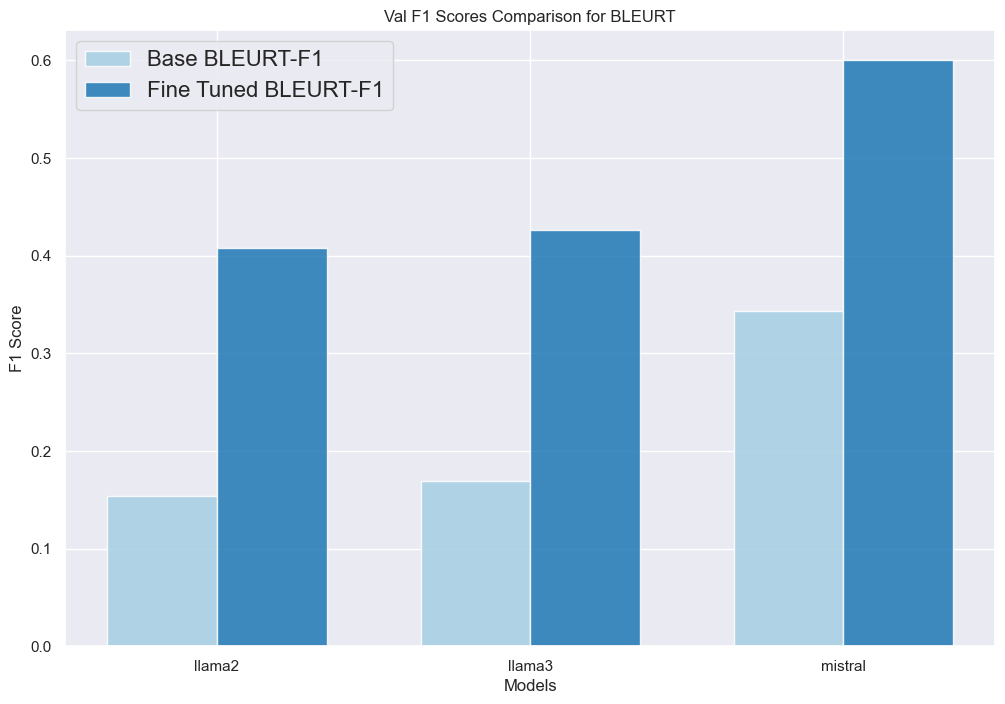

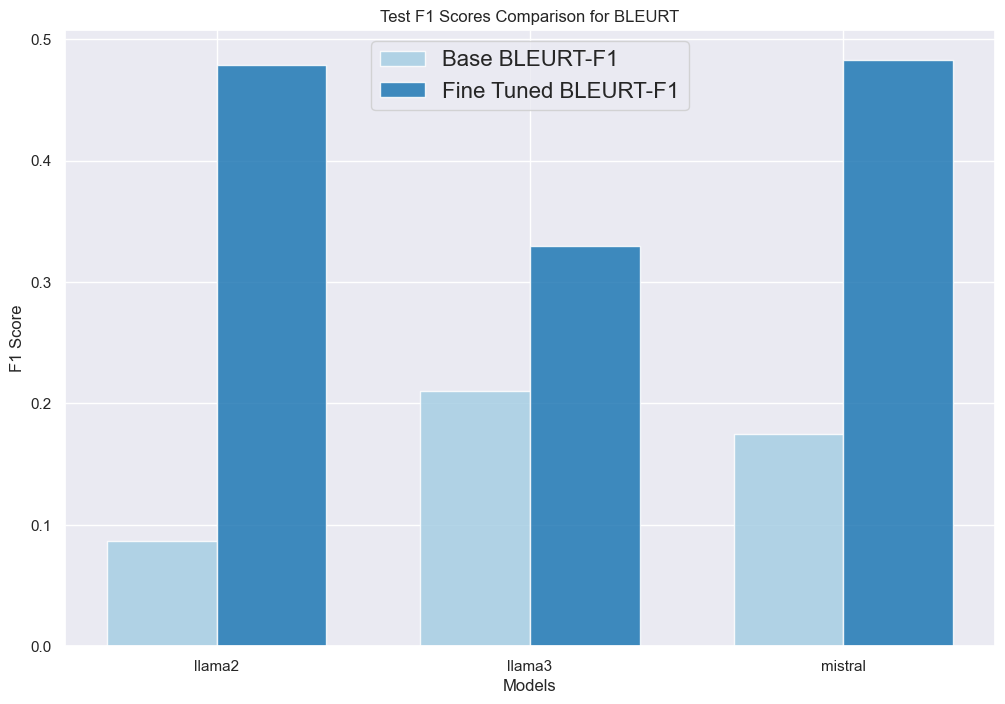

In [110]:
# makea bar plot for pre vs post fine tuning for test and val bar chart colored by model for bleurt use scores_df

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#set teh color pallete
sns.set(style="darkgrid")
sns.set_palette("Paired")
# sns.set(style="darkgrid")
# Provided dataset


df = pd.DataFrame(data)

# Separate pre and post fine-tuning data
pre_df = scores_df
post_df = scores_df_tuned

# Function to plot the grouped bar chart
def plot_grouped_bars_single_metric(pre_df, post_df, dataset_type, metric):
    labels = pre_df['Model'].str.split('-').str[1].unique()
    
    x = range(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))

    pre_scores = pre_df[pre_df['Model'].str.contains(dataset_type)][metric].values
    post_scores = post_df[post_df['Model'].str.contains(dataset_type)][metric].values

    ax.bar([p - width/2 for p in x], pre_scores, width, label=f'Base BLEURT-F1',alpha=0.85)
    ax.bar([p + width/2 for p in x], post_scores, width, label=f'Fine Tuned BLEURT-F1',alpha=0.85)

    ax.set_xlabel('Models')
    ax.set_title(f'{dataset_type.capitalize()} F1 Scores Comparison for BLEURT')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('F1 Score')
    #make the legend and text bigger
    ax.legend(fontsize=16)
    plt.show()

# Plot for validation
plot_grouped_bars_single_metric(pre_df, post_df, 'val', 'F1_bleurt')

# Plot for testing
plot_grouped_bars_single_metric(pre_df, post_df, 'test', 'F1_bleurt')